In [4]:
!pip install matplotlib-venn

In [5]:
# INSTALL ALL THE NECESSARY PACKAGES IN ANACONDA NAVIGATOR TO AVOID ERRORS IN RUNNING THE CODE BLOCK

import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import graphviz
import pydot

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ( 
    BatchNormalization, SeparableConv2D, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from os import listdir
print("Installation Confirmed")

Installation Confirmed


In [6]:
# SET THE DATA DIRECTORY AS PLANTVILLAGE

data_dir = 'plantvillage'

In [7]:
# SHUFFLING AND RESIZING THE IMAGES FOR THE MODEL

dataset = tf.keras.utils.image_dataset_from_directory(
          "plantvillage",
          shuffle = True,
          image_size = (64, 64))

Found 14529 files belonging to 10 classes.


In [8]:
# CHECK THE CLASS LABELS

class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [9]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
# CHECK DATASET DISTRIBUTION

y = np.concatenate([y for x, y in dataset], axis=0)
print(np.bincount(y))

[1702  800 1527  761 1417 1341 1123 4286  299 1273]


In [25]:
# SPLIT THE DATASET WITH THE FOLLOWING RATIO 7:2:1

def get_partition(ds,train_split = 0.7, validate = 0.2, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
    train_size = int(train_split*ds_size)
    val_size = int(validate*ds_size)
    train = ds.take(train_size)
    val = ds.skip(train_size).take(val_size)
    test = ds.skip(train_size).skip(val_size)
    return train,val,test  

In [26]:
train,val,test = get_partition(dataset)

In [27]:
len(train)

318

In [28]:
# OPTIMIZATON OF PIPELINES USING THE PREFETCH AND CACHE [THIS WILL READ AND STORE THE SAME IMAGE FOR FUTURE USE IN THE ITERATION]

train = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [29]:
# DATA AUGMENTATION [THIS IS TO MAKE OUR DATASET LARGER BY FLIPPING APPLYING HORIZONTAL FLIP, ROTATION, ZOOM, AND CONSTRASTING TO THE IMAGE
# AND USING THE AUGMENTED IMAGE FOR TESTING]

data_augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)   
])   

In [30]:
# USING THE AUGMENTED IMAGE FOR THE MODEL TRAINING 

train = train.map(lambda x, y: (data_augment(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
# PRE-PROCESS RESCALING OF THE INPUTS

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [24]:
# INITIALIZING THE PRE-TRAINED MOBILENETV2 MODEL 

IMG_SHAPE =  (64,64)+ (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [32]:
# CONVERT THE 64X64X3 IMAGE INTO A BLOCK OF FEATURES 

image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 2, 2, 1280)


In [33]:
# FREEZING THE BASE MODEL TRAINABLE TO PREVENT WEIGHTS FROM BEING UPDATED AND TO NOT LOSE WHAT THE PRE-TRAINED MODEL
# HAS ALREADY LEARNED

base_model.trainable = False

In [34]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 8, 8, 144)   576         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 8, 8, 144)    0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 8, 8, 32)     4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 8, 8, 32)    128         ['block_3_project[0][0]']        
 lization)                                                                                        
          

                                                                                                  
 block_7_expand_relu (ReLU)     (None, 4, 4, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 4, 4, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 4, 4, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_depthwise_relu (ReLU)  (None, 4, 4, 384)    0           ['block_7_depthwise_BN[0][0]']   
          

 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 4, 4, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 4, 4, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 4, 4, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_depthwise (DepthwiseC  (None, 4, 4, 576)   5184        ['block_11_expand_relu[0][0]']   
 onv2D)   

 block_14_depthwise_relu (ReLU)  (None, 2, 2, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 2, 2, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 2, 2, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 2, 2, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
                                                                                                  
 block_15_

In [35]:
# ADD THE GLOBALAVERAGEPOOLING2D TO CONVERT THE FEATURES TO A SINGLE 1280-ELEMENT VECTOR PER IMAGE 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [36]:
# ADD THE SOFTMAX FUNCTION TO GENERATE THE PREDICTIONS

prediction_layer = tf.keras.layers.Dense(10, activation="softmax")

In [37]:
# BUILD THE MODEL

inputs = tf.keras.Input(shape=(64, 64, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [38]:
# MODEL COMPILING 

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [40]:
# SET THE INITIAL EPOCHS TO 30 

initial_epochs = 30

loss0, accuracy0 = model.evaluate(val)

91/91 [==============================] - 23s 101ms/step - loss: 3.1097 - accuracy: 0.0883


In [41]:
# CHECK THE INITIAL LOSS AND THE INITIAL ACCURACY OF THE MODEL

print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

Initial loss: 3.11
Initial accuracy: 0.09


In [42]:
# TRAIN THE MODEL [FIRST PHASE TRAINING]

history = model.fit(train,epochs=initial_epochs,validation_data=val, batch_size = 32, verbose =1)

Epoch 1/30
318/318 [==============================] - 47s 124ms/step - loss: 2.0436 - accuracy: 0.3267 - val_loss: 1.7026 - val_accuracy: 0.4334
Epoch 2/30
318/318 [==============================] - 36s 112ms/step - loss: 1.4611 - accuracy: 0.5144 - val_loss: 1.4166 - val_accuracy: 0.5278
Epoch 3/30
318/318 [==============================] - 37s 116ms/step - loss: 1.2752 - accuracy: 0.5729 - val_loss: 1.2542 - val_accuracy: 0.5731
Epoch 4/30
318/318 [==============================] - 39s 123ms/step - loss: 1.1738 - accuracy: 0.6112 - val_loss: 1.1779 - val_accuracy: 0.6016
Epoch 5/30
318/318 [==============================] - 39s 123ms/step - loss: 1.1022 - accuracy: 0.6325 - val_loss: 1.1233 - val_accuracy: 0.6095
Epoch 6/30
318/318 [==============================] - 41s 130ms/step - loss: 1.0371 - accuracy: 0.6522 - val_loss: 1.0705 - val_accuracy: 0.6356
Epoch 7/30
318/318 [==============================] - 42s 131ms/step - loss: 1.0008 - accuracy: 0.6662 - val_loss: 1.0306 - val_ac

In [43]:
# UN-FREEZE THE TOP LAYER OF THE BASE MODEL

base_model.trainable = True

In [44]:
# CHECK THE LAYERS IN THE MODEL

print("LAYERS IN THE BASE MODEL: ", len(base_model.layers))


# FINE TUNING

fine_tune_at = 100


# FREEZE THE LAYERS BEFORE THE MODEL FINE TUNING

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

LAYERS IN THE BASE MODEL:  154


In [45]:
# COMPILE THE FINE-TUNED MODEL

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [47]:
len(model.trainable_variables)

56

In [48]:
# FINAL MODEL TRAINING [SECOND PHASE TRAINING]

fine_tune_epochs = 1
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train,epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=val,batch_size = 32,verbose =1)

Epoch 30/31
318/318 [==============================] - 73s 207ms/step - loss: 0.8818 - accuracy: 0.7043 - val_loss: 0.6436 - val_accuracy: 0.7850
Epoch 31/31
318/318 [==============================] - 60s 188ms/step - loss: 0.5572 - accuracy: 0.8122 - val_loss: 0.4544 - val_accuracy: 0.8492


In [49]:
# FINAL MODEL EVALUATION

scores = model.evaluate(test)

print('Test Loss:',scores[0] * 100,'%') 
print('Test Accuracy:',scores[1] * 100,'%')

46/46 [==============================] - 13s 107ms/step - loss: 0.4269 - accuracy: 0.8573
Test Loss: 42.68977642059326 %
Test Accuracy: 85.7336938381195 %


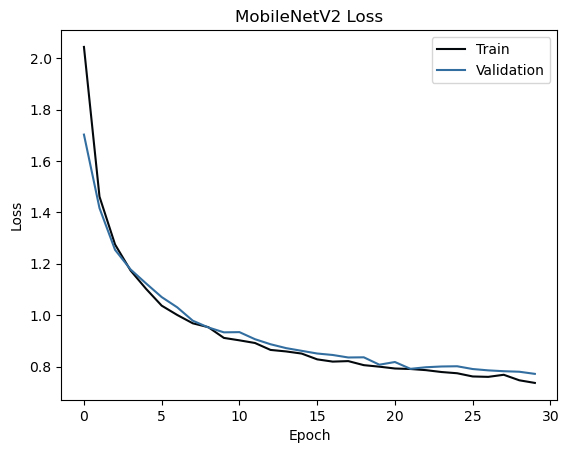

In [50]:
# MOBILENETV2 ACCURACY PLOT TO CHECK THE LOSS 

plt.plot(history.history['loss'], '#03080c')
plt.plot(history.history['val_loss'], '#336ea0')
plt.title('MobileNetV2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper right')
plt.show()

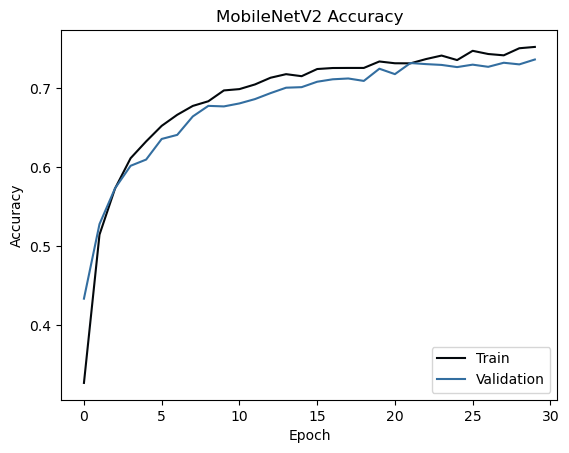

In [51]:
# MOBILENETV2 ACCURACY PLOT TO CHECK THE ACCURACY

plt.plot(history.history['accuracy'], '#03080c')
plt.plot(history.history['val_accuracy'], '#336ea0')
plt.title('MobileNetV2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='lower right')
plt.show()

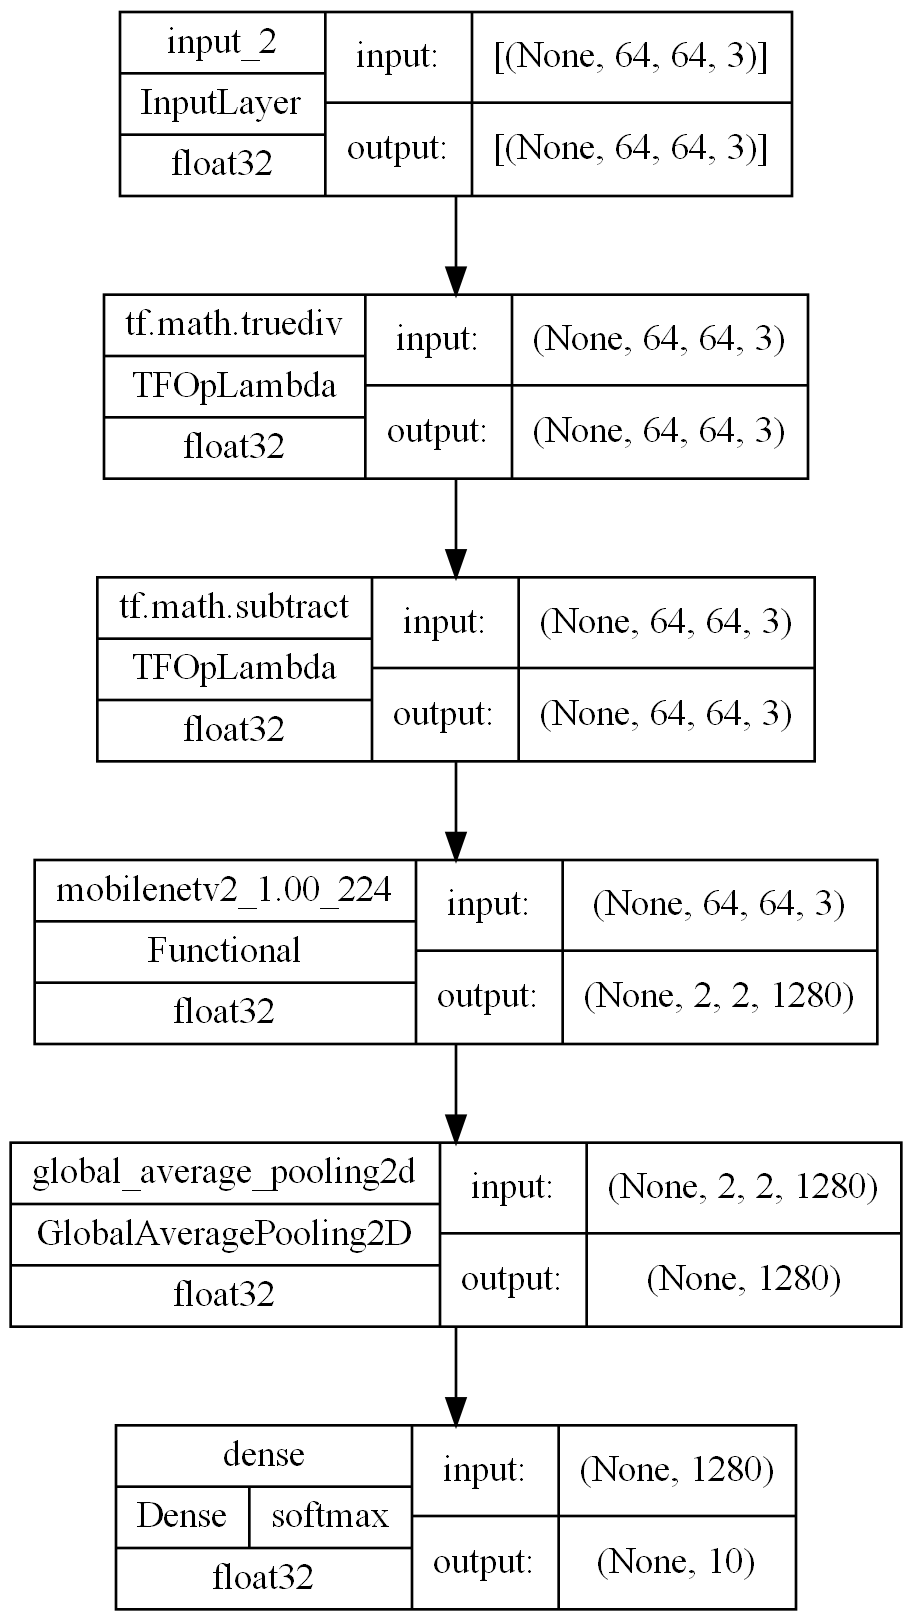

In [52]:
# PRINT THE ENTIRE MOBILENETV2 ARCHITECTURE

plot_model(
    model,
    to_file='mobilenetv2.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=192,
    layer_range=None,
    show_layer_activations=True
)

1/1 [==============================] - 0s 117ms/step
Actual:  Tomato___Bacterial_spot
Prediction:  Tomato___Bacterial_spot


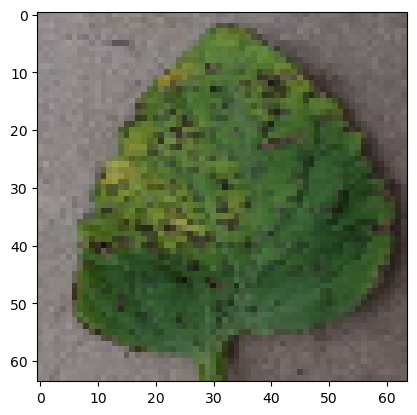

In [57]:
# TEST RUN THE MODEL (IT GETS RANDOM IMAGES FROM THE DATASET TEST AND PASS IT THROUGH THE MODEL)

for image_batch,label_batch in test.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    batch_prediction = model.predict(image_batch)
    
    plt.imshow(first_image)
    print("Actual: ",class_names[first_label])
    
    print("Prediction: ",class_names[np.argmax(batch_prediction[0])])